In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
from scipy import ndimage
from func import *
import astropy.units as u
from astropy.cosmology import FlatLambdaCDM

/home/mainak/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/home/mainak/.local/lib/python2.7/site-packages/pyneb/utils/manage_atomic_data.py:528: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  gsconf = np.genfromtxt(execution_path('../atomic_data/levels/gsconfs.dat'), names=['atom', 'gsconf'], dtype=None)


In [2]:
def flux_blr(Hb1_blr_br_data,Hb2_blr_br_data,sigma_eff_Hb1,sigma_eff_Hb2,broad2=False):
    flux1 = np.sum(Hb1_blr_br_data)*(np.sqrt(2.*np.pi)*np.fabs(sigma_eff_Hb1))
    flux2 = np.sum(Hb2_blr_br_data)*(np.sqrt(2.*np.pi)*np.fabs(sigma_eff_Hb2)) 
    if broad2:
        flux = (flux1 + flux2)*(10**(-16))
    else:
        flux = flux1*(10**(-16)) 
    return flux

def Hb_blr_lum(z,flux):
    cosmo = FlatLambdaCDM(H0=70 * u.km / u.s / u.Mpc, Om0=0.3)
    D_L = cosmo.luminosity_distance(z)
    dist = D_L.to(u.cm)
    Hb_lum = np.log10(4*np.pi)+2*np.log10(dist.value)+np.log10(flux)
    return Hb_lum


def energetics(vel_off,Hb_wing_lum,n_e,d_outflow):   
    print vel_off,Hb_wing_lum,n_e,d_outflow
    E_kin_outflow_rate = (100.0/n_e)*(Hb_wing_lum/(10**41))*np.power(vel_off/100.0,3)*(1000.0/d_outflow) # in terms of 10**40 erg/s
    M_outflow_rate = (100.0/n_e)*(Hb_wing_lum/(10**41))*(vel_off/100.0)*(1000.0/d_outflow) # in terms of 3M_s/ year where M_s = Solar Mass
    P_outflow_rate = M_outflow_rate*vel_off #multiplied by 3M_s/year
    return E_kin_outflow_rate,M_outflow_rate,P_outflow_rate

    
def ratio_offset_vel_line_shape(vel_offset,vel_sigma_OIII_br):
    ratio = (vel_offset/vel_sigma_OIII_br)
    return ratio

def line_shape_par(z,wav_min,wav_max,cor_popt):
    c = 3*(10**5)
    wave = np.arange(wav_min,wav_max,0.02) 
    cumsum = np.cumsum(OIII_wo_cont(wave,*cor_popt))
    norm_sum=cumsum/cumsum[-1]
    
    select = (norm_sum>0.1) & (norm_sum<0.9)
    w80_spec = wave[select][-1]-wave[select][0]
    plt.plot(wave[select],norm_sum[select],'-k')
    plt.xlim([wav_min+85,wav_max-85])
    plt.show()
    
    select =  (norm_sum>0.05) & (norm_sum<0.5)
    v5_spec = wave[select][0]-wave[select][-1]
    plt.plot(wave[select],norm_sum[select],'-b')
    plt.xlim([wav_min,wav_max])
    plt.show()
    
    [w80,v5] = [((w80_spec)/5006.8)*(c/(1+z)),((v5_spec)/5006.8)*(c/(1+z))]
    return w80,v5


def blr_sigma(obj,z,wo_wave,amp_Hb1,vel_Hb1,vel_sigma_Hb1,amp_Hb2,vel_Hb2,vel_sigma_Hb2):
    c = 300000
    k = 1+z
    select = (wo_wave>4750*k) & (wo_wave < 5090*k)
    m_0 = np.sum(double_BLR(wo_wave[select],amp_Hb1,vel_Hb1,vel_sigma_Hb1,amp_Hb2,vel_Hb2,vel_sigma_Hb2))
    m_1 = np.sum(wo_wave[select]*double_BLR(wo_wave[select],amp_Hb1,vel_Hb1,vel_sigma_Hb1,amp_Hb2,vel_Hb2,vel_sigma_Hb2))/m_0
    m_2 = np.sqrt(np.sum(double_BLR(wo_wave[select],amp_Hb1,vel_Hb1,vel_sigma_Hb1,amp_Hb2,vel_Hb2,vel_sigma_Hb2)*(wo_wave[select]-m_1)**2)/m_0)
    sigma_Hb_blr = c*(m_2)/m_1
    return sigma_Hb_blr

def blr_FWHM(obj,z,wo_wave,data,amp_Hb1,vel_Hb1,vel_sigma_Hb1,amp_Hb2,vel_Hb2,vel_sigma_Hb2):
    c = 300000
    k = 1+z
    select = (wo_wave>4750*k) & (wo_wave<5090*k)
    (wav,dat) = (wo_wave[select],double_BLR(wo_wave[select],amp_Hb1,vel_Hb1,vel_sigma_Hb1,amp_Hb2,vel_Hb2,vel_sigma_Hb2))
    amp = np.max(dat)
    select = (dat>amp/2) & (dat<amp)
    fwhm = wav[select][-1] - wav[select][0]
    fwhm = (fwhm/4861.33)*(c/(1+z))
    return fwhm

def par5100(z,m,c,wavelength=5100):
    k = 1 + z
    flux_den = (m*wavelength*k/1000.0) + c
    flux = k*wavelength*flux_den*(10**(-16))
    cosmo = FlatLambdaCDM(H0=70 * u.km / u.s / u.Mpc, Om0=0.3)
    D_L = cosmo.luminosity_distance(z)
    dist = D_L.to(u.cm)
    log_lum = np.log10(4*np.pi)+2*np.log10(dist.value)+np.log10(flux)
    lum = 10**log_lum
    #print flux_den,flux,lum,dist.value
    return flux_den,flux,lum
    
def logMBH(Hb_fwhm,lum_5100):
    logMBH=np.log10((Hb_fwhm/1000)**2*(lum_5100/10**(44))**0.5)+6.91 
    return logMBH

def edd_lum(log_MBH):
    lum = 1.25*(10**38)*(10**log_MBH)
    return lum

def log_L_OIII_total(obj):
    hdu = fits.open('%s_par_table_spec.fits'%(obj))
    central_tab = hdu[1].data
    central_columns = hdu[1].header
    total_lum = central_tab.field('log_L_OIII')
    return total_lum
    
def par_tab(obj,w80,v5,vel_offset,vel_sigma_OIII_br,ratio,flux,Hb_lum,Hb_sigma,Hb_fwhm,lum_5100,log_MBH,L_edd,Hb_wing_lum):
    par = [w80,v5,vel_offset,vel_sigma_OIII_br,ratio,flux,Hb_lum,Hb_sigma,Hb_fwhm,lum_5100,log_MBH,L_edd,Hb_wing_lum]
    column_names={'w80':0,'v5':1,'vel_offset':2,'vel_sigma_OIII_br':3,'ratio':4,'blr_flux':5,'log_Hb_blr_lum':6,'Hb_sigma':7,'Hb_fwhm':8,'lum_5100':9,'log_MBH':10,'L_edd':11,'log_Hb_wing_lum':12}
    columns=[]
    for key in column_names.keys():
        columns.append(fits.Column(name=key,format='E',array=[par[column_names[key]]]))
    coldefs = fits.ColDefs(columns)
    hdu = fits.BinTableHDU.from_columns(coldefs)
    hdu.writeto('%s_par_table.fits'%(obj),overwrite=True)   
    
def energetics_tab(obj,E_rate,M_rate,P_rate,log_L_5100,Hb_lum,log_total_OIII_lum):
    log_E_rate = 40.0 + np.log10(E_rate) 
    log_M_rate = 33.0 + np.log10(6) + np.log10(M_rate)
    log_P_rate = 33.0 + np.log10(6) + np.log10(P_rate) 
    par = [log_E_rate,log_M_rate,log_P_rate,log_L_5100,Hb_lum,log_total_OIII_lum]
    column_names={'log_E_rate':0,'log_M_rate':1,'log_P_rate':2,'log_L_5100':3,'log_L_Hb_BLR':4,'log_L_OIII_tot':5}
    columns=[]
    for key in column_names.keys():
        columns.append(fits.Column(name=key,format='E',array=[par[column_names[key]]]))
    coldefs = fits.ColDefs(columns)
    hdu = fits.BinTableHDU.from_columns(coldefs)
    hdu.writeto('%s_energetics_table.fits'%(obj),overwrite=True)  
    


In [3]:
def algorithm_script(obj,z,broad2):
    print '%s'%(obj)
    (wo_cube,wo_err,wo_wave,wo_header) = loadCube('%s.wo_absorption.fits'%(obj))

    [brightest_pixel_x,brightest_pixel_y] = central_pixel(obj)
    [brightest_pixel_x,brightest_pixel_y] = [int(brightest_pixel_x),int(brightest_pixel_y)]
    
    (data,error) = (wo_cube[:,brightest_pixel_y,brightest_pixel_x],wo_err[:,brightest_pixel_y,brightest_pixel_x])
    
    (amp_Hb1,amp_Hb2,vel_Hb1,vel_Hb2,vel_sigma_Hb1,vel_sigma_Hb2,amp_OIII5007,vel_OIII,vel_sigma_OIII,amp_OIII5007_br,vel_OIII_br,vel_sigma_OIII_br,vel_offset,m,c) = par(obj)
    (Hb1_blr_br_data,Hb2_blr_br_data) = loadblr('subcube_par_%s.fits'%(obj))
    Hb_br_data = loadHbwing('subcube_par_%s.fits'%(obj))
    
    sigma_eff_Hb1 = line_width_recons(vel_sigma_Hb1,rest_line=4861.33,inst_res_fwhm=0)
    sigma_eff_Hb2 = line_width_recons(vel_sigma_Hb2,rest_line=4861.33,inst_res_fwhm=0) 
    sigma_eff_Hb_br = line_width_recons(vel_sigma_OIII_br,rest_line=4861.33,inst_res_fwhm=0) 
    
    (flux) = flux_blr(Hb1_blr_br_data,Hb2_blr_br_data,sigma_eff_Hb1,sigma_eff_Hb2,broad2)
    
    ratio_Hb_OIII = Hb_OIII_wing_ratio(obj)
    
    L_OIII_br = OIII_br_lum(obj)
    log_total_OIII_lum = log_L_OIII_total(obj)
    
    Hb_wing_lum = ratio_Hb_OIII*L_OIII_br
    Hb_lum= Hb_blr_lum(z,flux)
    
    print "amp_Hb_br/amp_OIII5007_br is",ratio_Hb_OIII,
    print "luminosity of OIII_br is", L_OIII_br
    print "luminosity of NLR Hb_br is",Hb_wing_lum
    
    vel_off = vel_OIII - vel_OIII_br  
    n_e = electron_density_wing(obj)
    d_outflow = outflow_radius(obj)

    (E_rate,M_rate,P_rate) = energetics(vel_off,Hb_wing_lum,n_e,d_outflow)
    print "energy outflow rate is(in terms of 10^40 erg/s)",E_rate
    print "mass outflow rate is(in terms of 3M_s/year)",M_rate
    print "momentum outflow rate (multiplied by 3M_s/year)", P_rate
    
    Hb_sigma = blr_sigma(obj,z,wo_wave,amp_Hb1,vel_Hb1,vel_sigma_Hb1,amp_Hb2,vel_Hb2,vel_sigma_Hb2)
    Hb_fwhm = blr_FWHM(obj,z,wo_wave,data,amp_Hb1,vel_Hb1,vel_sigma_Hb1,amp_Hb2,vel_Hb2,vel_sigma_Hb2)
    
    (flux_den_5100,flux_5100,lum_5100) = par5100(z,m,c,wavelength=5100)
    log_L_5100 = np.log10(lum_5100)
    log_MBH = logMBH(Hb_fwhm,lum_5100)
    L_edd = edd_lum(log_MBH)
                       
    cor_popt = np.array([amp_OIII5007,amp_OIII5007_br,vel_OIII,vel_sigma_OIII,vel_OIII_br,vel_sigma_OIII_br])
    
    (wav_min,wav_max) = wavlim(vel_OIII,vel_OIII_br)
    (w80,v5) = line_shape_par(z,wav_min,wav_max,cor_popt)
    
    ratio = ratio_offset_vel_line_shape(vel_offset,vel_sigma_OIII_br)
    par_tab(obj,w80,v5,vel_offset,vel_sigma_OIII_br,ratio,flux,Hb_lum,Hb_sigma,Hb_fwhm,lum_5100,log_MBH,L_edd,Hb_wing_lum)
    energetics_tab(obj,E_rate,M_rate,P_rate,log_L_5100,Hb_lum,log_total_OIII_lum)

HE0119-0118
amp_Hb_br/amp_OIII5007_br is 0.049011976 luminosity of OIII_br is 4.6572846442271935e+41
luminosity of NLR Hb_br is 2.282627210042498e+40
208.55371 2.282627210042498e+40 800.9476 49.690662
energy outflow rate is(in terms of 10^40 erg/s) 5.20247355453804
mass outflow rate is(in terms of 3M_s/year) 1.1961180313385675
momentum outflow rate (multiplied by 3M_s/year) 249.45485415491518


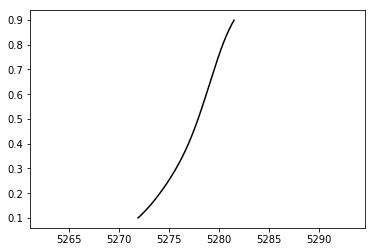

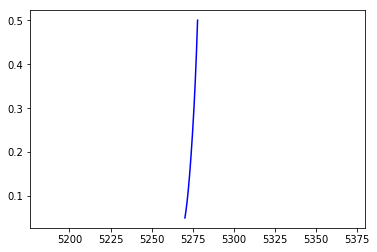

In [4]:
z = {"HE0119-0118":0.054341}#"HE0253-1641":0.031588,"HE2302-0857":0.046860}

#z_remaining = {"HE2128-0221":0.05248,"HE1248-1356":0.01465}

broad2= {'HE0119-0118':True}#,'HE0253-1641':True,'HE2302-0857':True}

objs = z.keys()

for obj in objs:
    algorithm_script(obj,z[obj],broad2[obj])
     
     #from the central pixel fit of Hb_br/ OIII_br , multiply this ratio with broad OIII luminosity to get H-beta luminosity 

HE0224-2834
amp_Hb_br/amp_OIII5007_br is 0.07028452 luminosity of OIII_br is 2.0980851993879234e+41
luminosity of NLR Hb_br is 1.4746291759890928e+40
21.365234 1.4746291759890928e+40 3072.3726 46.151997
energy outflow rate is(in terms of 10^40 erg/s) 0.0010142416356671857
mass outflow rate is(in terms of 3M_s/year) 0.022219082018746728
momentum outflow rate (multiplied by 3M_s/year) 0.474715894927872


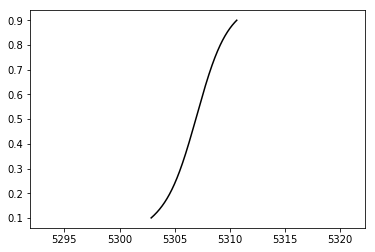

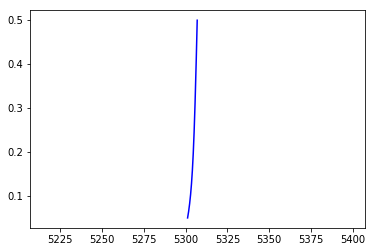

HE0433-1028
amp_Hb_br/amp_OIII5007_br is 0.11148491 luminosity of OIII_br is 3.5310279362720185e+41
luminosity of NLR Hb_br is 3.9365632309355e+40
310.10645 3.9365632309355e+40 2730.884 15.006064
energy outflow rate is(in terms of 10^40 erg/s) 28.647026211801286
mass outflow rate is(in terms of 3M_s/year) 2.9789139612908877
momentum outflow rate (multiplied by 3M_s/year) 923.7804194276954


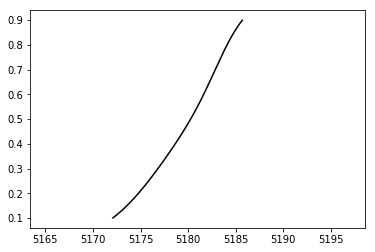

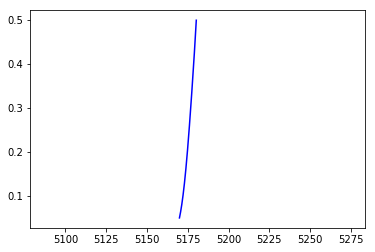

HE0040-1105
amp_Hb_br/amp_OIII5007_br is 0.15718926 luminosity of OIII_br is 5.161729689332637e+40
luminosity of NLR Hb_br is 8.113684954453155e+39
164.55469 8.113684954453155e+39 1913.4071 85.613655
energy outflow rate is(in terms of 10^40 erg/s) 0.2206980489977532
mass outflow rate is(in terms of 3M_s/year) 0.08150382255023192
momentum outflow rate (multiplied by 3M_s/year) 13.411836049808867


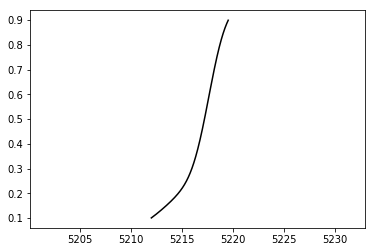

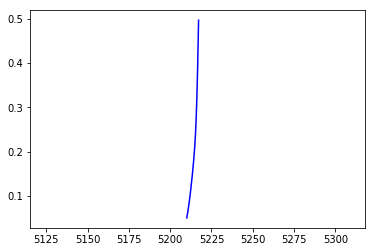

HE0253-1641
amp_Hb_br/amp_OIII5007_br is 0.17226695 luminosity of OIII_br is 2.3481385815861202e+41
luminosity of NLR Hb_br is 4.0450666045679424e+40
250.64551 4.0450666045679424e+40 4944.523 7.675201
energy outflow rate is(in terms of 10^40 erg/s) 16.78383888494439
mass outflow rate is(in terms of 3M_s/year) 2.6716001004457537
momentum outflow rate (multiplied by 3M_s/year) 669.624563848152


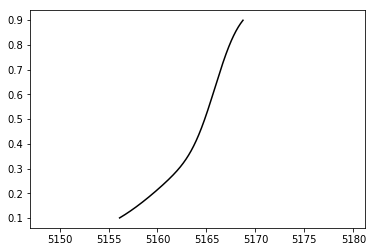

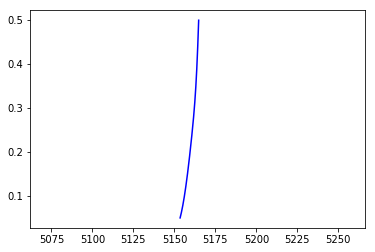

HE0119-0118
amp_Hb_br/amp_OIII5007_br is 0.049011976 luminosity of OIII_br is 4.6572846442271935e+41
luminosity of NLR Hb_br is 2.282627210042498e+40
208.55371 2.282627210042498e+40 800.9476 49.690662
energy outflow rate is(in terms of 10^40 erg/s) 5.20247355453804
mass outflow rate is(in terms of 3M_s/year) 1.1961180313385675
momentum outflow rate (multiplied by 3M_s/year) 249.45485415491518


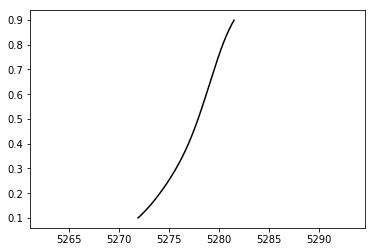

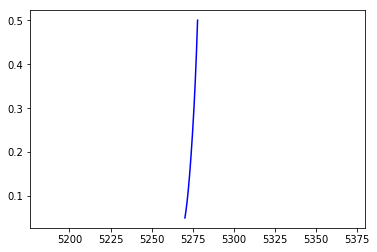

HE0108-4743
amp_Hb_br/amp_OIII5007_br is 0.082029305 luminosity of OIII_br is 2.9935910681037516e+40
luminosity of NLR Hb_br is 2.455621959635973e+39
66.978516 2.455621959635973e+39 752.27856 26.458672
energy outflow rate is(in terms of 10^40 erg/s) 0.037069893757270746
mass outflow rate is(in terms of 3M_s/year) 0.08263238813322202
momentum outflow rate (multiplied by 3M_s/year) 5.534594699712075


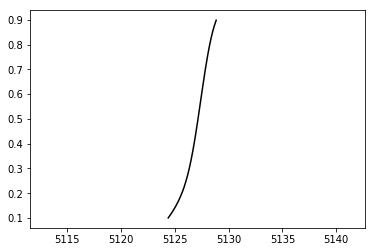

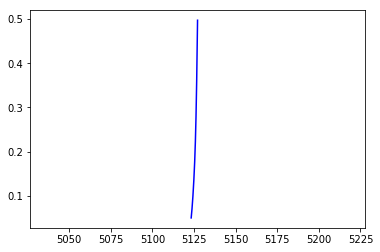

In [5]:
z = {"HE0040-1105":0.041692,"HE0119-0118":0.054341,"HE0224-2834":0.059800,"HE0253-1641":0.031588,"HE0433-1028":0.035550,"HE0108-4743":0.02392}

broad2= {'HE0040-1105':False,'HE0119-0118':True,'HE0224-2834':False,'HE0253-1641':True,'HE0433-1028':True,'HE0108-4743':True}
objs = z.keys()

for obj in objs:
    algorithm_script(obj,z[obj],broad2[obj])

In [2]:
import seaborn as sns
hdu = fits.open('outflow_energetics_table.fits')
central_tab = hdu[1].data
central_columns = hdu[1].header
log_L_OIII = central_tab.field('log_L_OIII_tot')
log_E_rate = central_tab.field('log_E_rate')
log_M_rate = central_tab.field('log_M_rate')
log_P_rate = central_tab.field('log_P_rate')
log_L_5100 = central_tab.field('log_L_5100')
log_L_Hb_BLR = central_tab.field('log_L_Hb_BLR')
log_L_bol = log_L_5100 + 1.0
from matplotlib import rcParams
rcParams['font.family'] = 'cambria'

/home/mainak/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family [u'cambria'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


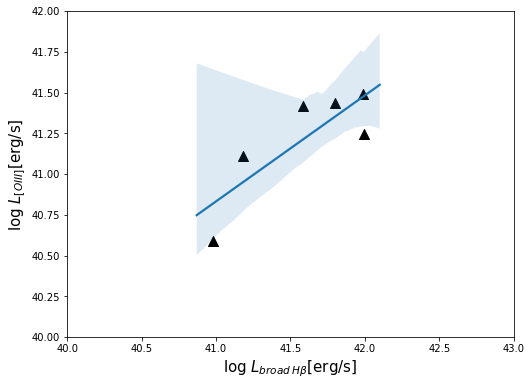

In [3]:
fig = plt.figure(figsize=(8,6))
sns.regplot(log_L_Hb_BLR, log_L_OIII, marker="^",scatter_kws={"color":"black","alpha":1.0,"s":100})
#plt.plot(log_L_Hb_BLR,log_L_OIII,'kx')
plt.xlabel(r'log $L_{broad \: H\beta}$[erg/s]',fontsize=15)
plt.ylabel(r'log $L_{[OIII]}$[erg/s]',fontsize=15)
plt.xlim(40,43)
plt.ylim(40,42)
fig.savefig('log_L_Hb_BLR vs log_L_OIII.png')

plt.show()

#scatter_kws={"color":"darkred","alpha":0.3,"s":200} )

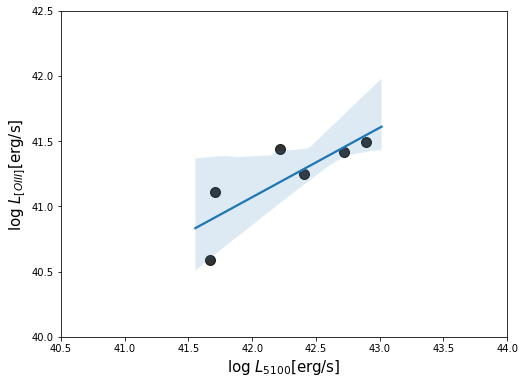

In [4]:
fig = plt.figure(figsize=(8,6))
sns.regplot(log_L_5100,log_L_OIII, marker="o",scatter_kws={"color":"black","alpha":0.8,"s":100})
plt.xlabel(r'log $L_{5100}$[erg/s]',fontsize=15)
plt.ylabel(r'log $L_{[OIII]}$[erg/s]',fontsize=15)
plt.xlim(40.5,44)
plt.ylim(40,42.5)
fig.savefig('log_L_5100 vs log_L_OIII.png')
plt.show()

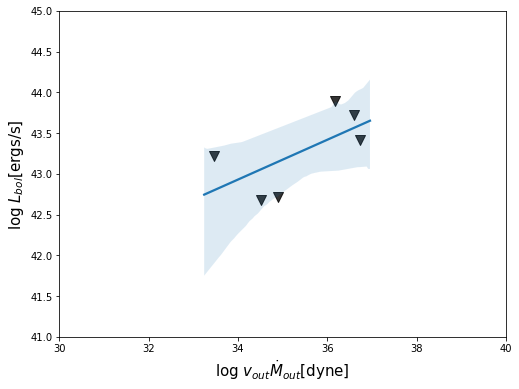

In [7]:
fig = plt.figure(figsize=(8,6))
sns.regplot(log_P_rate,log_L_bol, marker="v",scatter_kws={"color":"black","alpha":0.8,"s":100})
#plt.plot(log_P_rate,log_L_bol,'kx')
plt.xlabel(r'log $v_{out} \dot{M}_{out}$[dyne]',fontsize=15)
plt.ylabel(r'log $L_{bol}$[ergs/s]',fontsize=15)
#plt.xlabel('log_P_rate')
fig.savefig('log_P_rate vs log_L_bol.png')
plt.xlim(30,40)
plt.ylim(41,45)
plt.show()

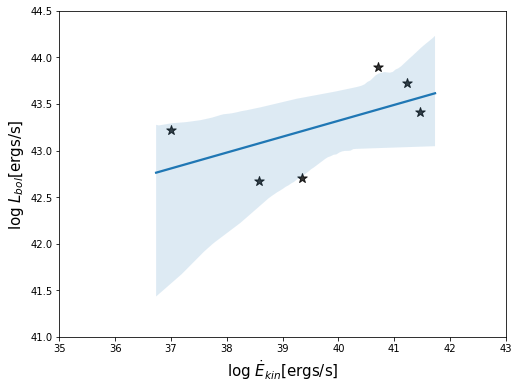

In [6]:
fig = plt.figure(figsize=(8,6))
sns.regplot(log_E_rate,log_L_bol, marker="*",scatter_kws={"color":"black","alpha":0.8,"s":100})
plt.xlabel(r'log $\dot{E}_{kin}$[ergs/s]',fontsize=15)
plt.ylabel(r'log $L_{bol}$[ergs/s]',fontsize=15)
fig.savefig('log_E_rate vs log_L_bol.png')
plt.xlim(35,43)
plt.ylim(41,44.5)
plt.show()